In [1]:
import shapely
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr

In [2]:
%matplotlib notebook

The first line of the file 'ATL11_errors_100820' is this:

ATL11_002803_0307_003_01.h5 | Spatial validation error: The polygon boundary intersected itself at the following points: [lon=74.0606220917933 lat=63.515758249560584],[lon=70.85791706371326 lat=73.18284416080927]

We should be able to use this to find the self intersection in the file.

Tyler provided code that lets us read the polygon out of the xml file.

In [3]:
import lxml.etree
import numpy as np
import shapely.geometry
# compile xml parsers for lxml
XMLparser = lxml.etree.XMLParser(recover=True, remove_blank_text=True)
# PURPOSE: parse xml header file and create shapely polygon
def parse_xml_file(xml_file, XMLparser):
    # read xml file and create lxml tree for parsing
    with open(xml_file, 'r') as fid:
        tree = lxml.etree.parse(fid,XMLparser)
    root = tree.getroot()
    LinearRing = root.findall('.//gml:Polygon/gml:exterior/gml:LinearRing/gml:posList', root.nsmap)
    # create a polygon for each linear ring
    poly_list = []
    for ring in LinearRing:
        coords = np.array(ring.text.split(),dtype='f')
        lon,lat = (coords[0:-1:2],coords[1::2])
        poly_list.append(shapely.geometry.Polygon(np.c_[lon, lat]))
    # create shapely polygon
    return shapely.geometry.MultiPolygon(poly_list)

In [4]:
P=parse_xml_file('ATL11_002803_0307_003_01.h5.iso.xml', XMLparser)

Make a numpy array out of the polygon and plot it:

<IPython.core.display.Javascript object>


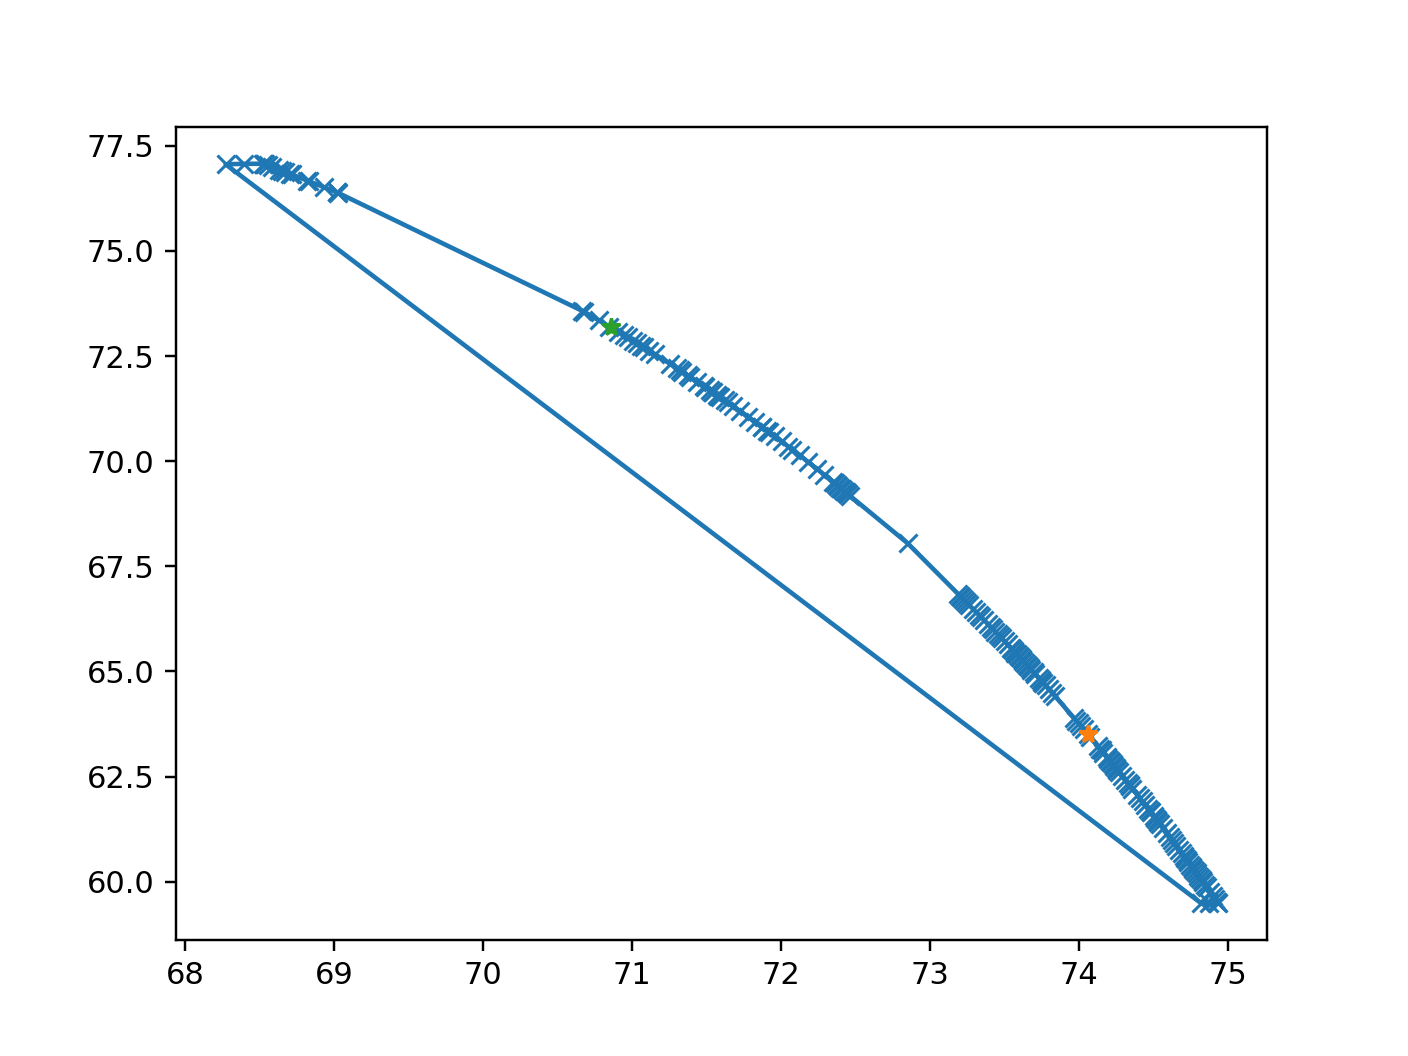

In [28]:
latlon=np.c_[[c for c in P[0].exterior.coords]]
plt.figure(); 
plt.plot(latlon[:,1], latlon[:,0], marker='x');


In [29]:
# lat and lon where ATL11_errors identified an intersection
lon=74.0606220917933;
lat=63.515758249560584;
plt.plot(lon, lat, '*')

# lat and lon where ATL11_errors identified an intersection
lon=70.85791706371326; 
lat=73.18284416080927;
plt.plot(lon, lat, '*');


I don't see any inersections!  Maybe if we zoom in on the places where the ATL11_errors claimed to find an intersecion, we'll see something:

<IPython.core.display.Javascript object>


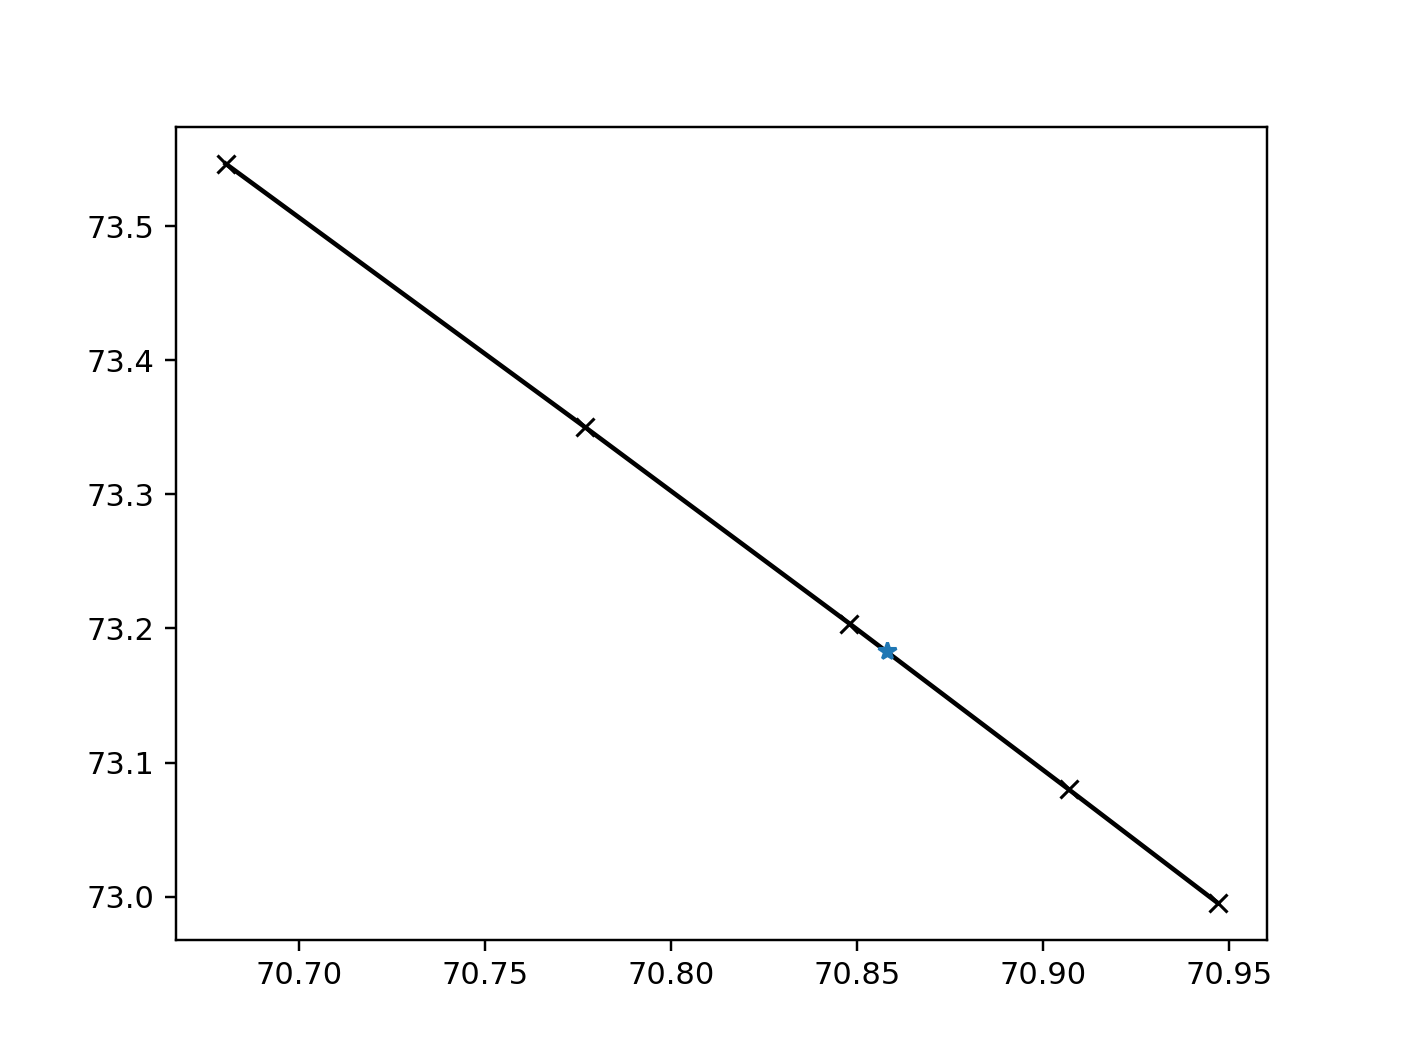

In [30]:
nearest=np.argmin((latlon[:,1]-lon)**2+(latlon[:,0]-lat)**2)
plt.figure();
plt.plot(latlon[nearest+np.arange(-2, 3), 1],latlon[nearest+np.arange(-2, 3), 0] ,'k', marker='x')
plt.plot(lon, lat,'*');

Nope again.  Maybe the latitude and longitude arrays contain duplicate coordinates:

In [31]:
print(np.min(np.abs(np.diff(latlon, axis=0)), axis=0))

[0.00104523 0.00124359]


Nope.  Subsequent points are at least a thousandth of a degree apart.  Maybe latitude and longitude contain out-of-sequence points:


<IPython.core.display.Javascript object>


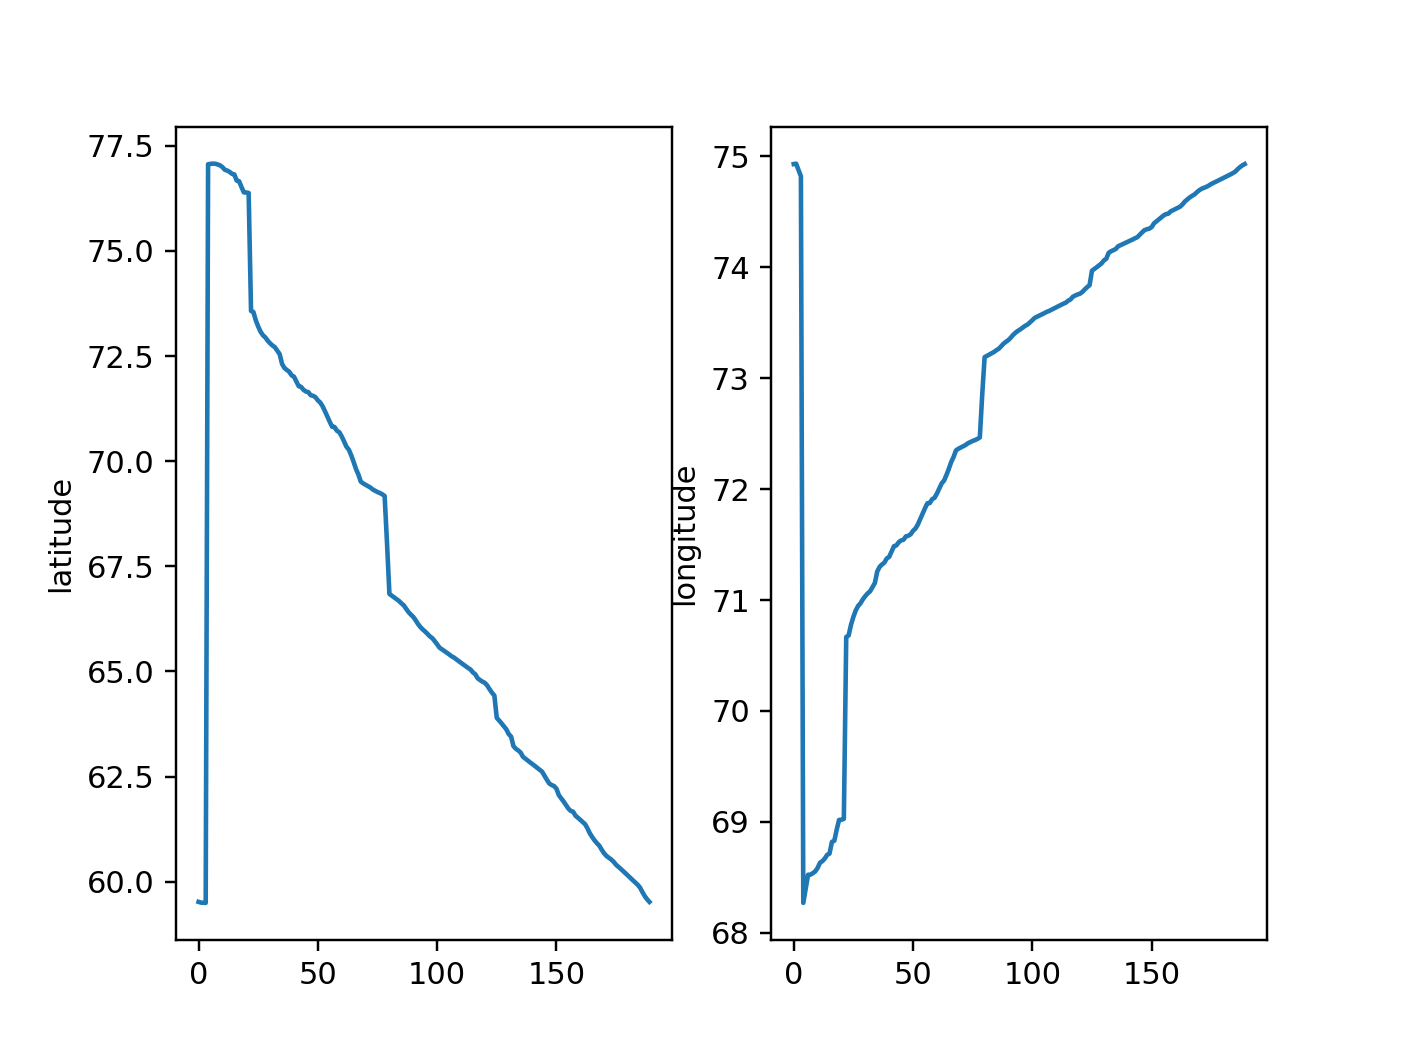

In [32]:
fig=plt.figure(); 
fig.add_subplot(121);
plt.plot(latlon[:,0]); plt.gca().set_ylabel('latitude')
fig.add_subplot(122);
plt.plot(latlon[:,1]); plt.gca().set_ylabel('longitude');

Nope again.  To all appearances, the polygon in the file is just fine.  